This notebook has been modified from SPECFEM Users Workshop by Visrutha 
visrutha.c@students.iiserpune.ac.in

This notebook is meant to walk Users through an introduction to `SPECFEM2D`, which includes:

    1) navigating a SPECFEM2D working directory
    2) generating a 2D mesh with a layered model
    3) running a forward simulation to generate synthetic seismograms   

### 1) SPECFEM2D Directory Tour

In [157]:
import numpy as np
import os
import matplotlib.pyplot as plt 
from IPython.display import Image
from scipy.interpolate import griddata


#### 1a) Getting started

To get started, do the following:

1. download specfem2d (*git clone*) : `git clone --recursive --branch devel https://github.com/SPECFEM/specfem2d.git`
1. configure (*./configure*) : `./configure FC=gfortran CC=gcc MPIFC=mpif90 --with-mpi` - can replace the GNU compilers above (gfortran and gcc) with other compilers if you want to; for instance for
Intel ifort and icc use FC=ifort CC=icc instead. If you plan to run on one processor, use `./configure FC=gfortran CC=gcc`
3. compile (*make all*) SPECFEM2D : `make all`  


In [8]:
#change your directory
%cd /home/visrutha/specfem2d 
! ls

/home/visrutha/specfem2d
AUTHORS        CONTRIBUTING.md	LICENSE       run_this_example.sh
bin	       DATA		m4	      setup
config.guess   doc		Makefile      src
config.log     DVP		Makefile.in   tests
config.status  EXAMPLES		my_examples   utils
config.sub     external_libs	obj	      VERSION
configure      flags.guess	OUTPUT_FILES
configure.ac   install-sh	README.md


### 1b) SPECFEM Executables in *bin/* directory
- Executables created by the compilation step are located in the `bin/` directory 

In [9]:
! ls bin

xadj_seismogram		      xconvolve_source_timefunction  xspecfem2D
xcheck_quality_external_mesh  xmeshfem2D		     xsum_kernels
xcombine_sem		      xsmooth_sem


The executables required to create seismograms are `xmeshfem2D` and `xspecfem2D`. 
- `xmeshfem2D`: generate a numerical mesh, the skeleton of the domain upon which we run our numerical simulations   
- `xspecfem2D`: run the spectral element solver, generates synthetic seismograms for a given source and set of stations 

### 1c) Parameters and Simulation Data in *DATA/* directory

- *DATA/* directory contains external data and control parameters provided to SPECFEM
- The most important files are: `Par_file`, `SOURCE` and `STATIONS`
    - `Par_file`: Parameter file used to control simulation  
    - `SOURCE`: Defines source location and mechanism (e.g moment tensor, force)
    - `STATIONS`: Defines station codes and locations (Cartesian or geographic) 

In [15]:
! ls DATA/

Par_file  SOURCE


#### Set Up a SPECFEM Working Directory

- It is often desireable to run SPECFEM outside of the cloned repository, in order to keep files and outputs manageable  
- The trick here is that SPECFEM **only** requires 3 compenents for a sucessful simulation: `bin/`, `DATA/`, and `OUTPUT_FILES/`  - Just copy the DATA directory I have shared along with this code to the specfem2d folder
- **Please change the folder directories accordingly.**

In [ ]:
# Create the correct dir. and move there
! mkdir -p /home/visrutha/work/specfem2d_workdir
%cd /home/visrutha/work/specfem2d_workdir

# Symlink the executables, create empty OUTPUT_FILES
! ln -s /home/visrutha/specfem2d/bin .
! mkdir OUTPUT_FILES

# copy the DATA directory I have shared along with this notebook
! cp -r /home/visrutha/specfem2d/DATA_example DATA

! ls

In [23]:
# After copying it should have all these files

! ls DATA/

interfaces.dat	Par_file  SOURCE  STATIONS


In [24]:
! head -35 DATA/Par_file


#-----------------------------------------------------------
#
# Simulation input parameters
#
#-----------------------------------------------------------

# title of job
title                           = Test of SPECFEM2D 

# forward or adjoint simulation
# 1 = forward, 2 = adjoint, 3 = both simultaneously
# note: 2 is purposely UNUSED (for compatibility with the numbering of our 3D codes)
SIMULATION_TYPE                 = 1
# 0 = regular wave propagation simulation, 1/2/3 = noise simulation
NOISE_TOMOGRAPHY                = 0
# save the last frame, needed for adjoint simulation
SAVE_FORWARD                    = .false.

# parameters concerning partitioning
NPROC                           = 1              # number of processes

# time step parameters
# total number of time steps
NSTEP                           = 1600

# duration of a time step (see section "How to choose the time step" of the manual for how to do this)
DT                              = 1.1d-3

# time stepping
# 1 = N

In [25]:
! head DATA/SOURCE
! echo "..."
! tail DATA/SOURCE

## Source 1
source_surf                     = .false.        # source inside the medium, or source automatically moved exactly at the surface by the solver
xs                              = 2500.          # source location x in meters
zs                              = 2500.          # source location z in meters (zs is ignored if source_surf is set to true, it is replaced with the topography height)
## Source type parameters:
#  1 = elastic force or acoustic pressure
#  2 = moment tensor
# or Initial field type (when initialfield set in Par_file):
# For a plane wave including converted and reflected waves at the free surface:
#  1 = P wave,
...
# The components of a moment tensor source must be given in N.m, not in dyne.cm as in the DATA/CMTSOLUTION source file of the 3D version of the code.
Mxx                             = 1.             # Mxx component (for a moment tensor source only)
Mzz                             = 1.             # Mzz component (for a moment tensor source only)

In [27]:
# Sometimes in SPECFEM2D, the Par_file defines station information directly given the "use_existing_STATIONS" is set to ".false.""

! head -185 DATA/Par_file | tail -n 7

# first receiver set (repeat these 6 lines and adjust nreceiversets accordingly)
nrec                            = 11             # number of receivers
xdeb                            = 300.           # first receiver x in meters
zdeb                            = 2200.          # first receiver z in meters
xfin                            = 3700.          # last receiver x in meters (ignored if only one receiver)
zfin                            = 2200.          # last receiver z in meters (ignored if only one receiver)
record_at_surface_same_vertical = .true.         # receivers inside the medium or at the surface (z values are ignored if this is set to true, they are replaced with the topography height)


### 1d) Results stored in *OUTPUT_FILES/* directory

- Outputs generated by SPECFEM are stored in the `OUTPUT_FILES/` directory. Make sure the directory exists.  
- Outputs include: log files, error messages, synthetic seismograms, figures, database files  
- Database files store information about the mesh and model  
- **SPECFEM3D NOTE:** SPECFEM3D maintains a separate database directory (typically called `DATABASES_MPI/`).

In [30]:
os.makedirs("OUTPUT_FILES", exist_ok=True)


-----------
## 2) Running the Mesher (`xmeshfem2D`)  

- We will use two terms to talk about meshing:  
    - **MESH**: a numerical grid which defines coordinate points only (i.e., X and Z in 2D).  
    - **MODEL**: parameter values (e.g., seismic velocity) approximating structure, assigned to locations on the MESH.  
- The first thing we need to do when approaching numerical simulations is to generate a numerical mesh   
- I use SPECFEM's internal mesher, `Meshfem`. External programs exist, such as [Gmsh](https://gmsh.info/) and [Trelis](https://coreform.com/products/coreform-cubit/) 

### 2a) Model Parameters

- In SPECFEM2D, *mesh* and *model* specifications are defined in the `Par_file`  
- In **SPECFEM3D**, mesh files are defined in a separate `Mesh_Par_file`, typically stored in `DATA/meshfem3D_files`.

- Look at the definition of the model in the Par_file - if you want to use internal mesher, set it to `default`

In [40]:
! head -65 DATA/Par_file | tail -n 1

MODEL                           = default


In [148]:
# 
! head -269 DATA/Par_file | tail -n 32

PERIODIC_HORIZ_DIST             = 4000.d0

#-----------------------------------------------------------
#
# Velocity and density models
#
#-----------------------------------------------------------

# number of model materials
nbmodels                        = 3
# available material types (see user manual for more information)
#   acoustic:              model_number 1 rho Vp 0  0 0 QKappa 9999 0 0 0 0 0 0 (for QKappa use 9999 to ignore it)
#   elastic:               model_number 1 rho Vp Vs 0 0 QKappa Qmu  0 0 0 0 0 0 (for QKappa and Qmu use 9999 to ignore them)
#   anisotropic:           model_number 2 rho c11 c13 c15 c33 c35 c55 c12 c23 c25   0 QKappa Qmu
#   anisotropic in AXISYM: model_number 2 rho c11 c13 c15 c33 c35 c55 c12 c23 c25 c22 QKappa Qmu
#   poroelastic:           model_number 3 rhos rhof phi c kxx kxz kzz Ks Kf Kfr etaf mufr Qmu
#   tomo:                  model_number -1 0 0 A 0 0 0 0 0 0 0 0 0 0
#
# note: When viscoelasticity or viscoacousticity is turned on,
#       

-------------------
- In the output above we can see that our `Par_file` defines 3 separate regions, each with varying values for density and velocity.

```bash
N - RHO     VP[m/s] VS[m/s]    - - QKAP QMU  - - - - -
1 1 2700.d0 3000.d0 1732.d0 0 0 9999 9999 0 0 0 0 0 0
2 1 2500.d0 2700.d0 1632.d0 0 0 9999 9999 0 0 0 0 0 0
3 1 2200.d0 2500.d0 1443.d0 0 0 9999 9999 0 0 0 0 0 0
```
- These regions have **no** sense of space. They only represent material properties.
- These regions will be assigned to parts of the *mesh* in the following section

### 2b) Mesh Parameters

- The internal mesher has a set of parameters that allows Users to provide: interfaces, geometry, boundary conditions.
    - **Interfaces** define the contact point between two mesh domains. Across an interface, mesh geometry and model parameters can change.
    - **Boundary conditions** define how waves interact with the edges of your finite domain. Often absorbing boundary conditions are used.
    - **Mesh geometry** can be optimized to reduce computational cost while keeping simulations stable.

In [51]:
! head -320 DATA/Par_file | tail -n 29

#
# PARAMETERS FOR INTERNAL MESHING
#
#-----------------------------------------------------------

# file containing interfaces for internal mesh
interfacesfile                  = /interfaces.dat

# geometry of the model (origin lower-left corner = 0,0) and mesh description
xmin                            = 0.d0           # abscissa of left side of the model
xmax                            = 4000.d0        # abscissa of right side of the model
nx                              = 80             # number of elements along X

# absorbing boundary parameters (see absorbing_conditions above)
absorbbottom                    = .true.
absorbright                     = .true.
absorbtop                       = .false.
absorbleft                      = .true.

# define the different regions of the model in the (nx,nz) spectral-element mesh
nbregions                       = 3              # then set below the different regions and model number for each region
# format of each line: nxmin nxmax nzmi

#### Understanding Internal Mesh Parameters
- In Meshfem2D we can set any of the 4 edges to be absoring
- The top boundary is often not absoring, to mimic surface reflections as you would have in the real world
- The section at the bottom partitions *materials* defined by the model, to *regions* of the mesh
- A separate *interface* file defines the shape of boundaries within the mesh

In [52]:
# Let's have a look at the `interfaces` file which defines boundary interfaces 
! cat DATA/interfaces.dat

#
# number of interfaces
#
 4
#
# for each interface below, we give the number of points and then x,z for each point
#
#
# interface number 1 (bottom of the mesh)
#
 2
 0 0
 4000 0
#
# interface number 2
#
 2
    0 1000
 4000 1000
#
# interface number 3
#
 2
    0 2000
 4000 2000
#
# interface number 4 (topography, top of the mesh)
#
 2
    0 3000
 4000 3000
#
# for each layer, we give the number of spectral elements in the vertical direction
#
#
# layer number 1 (bottom layer)
#
 20
#
# layer number 2
#
 20
#
# layer number 3 (top layer)
#
 20


#### Understanding Interface Files
- There are 4 interfaces defined in this file (bottom of mesh, 2 internal interfaces, top of mesh)   
- We define 20 elements in each layer for 60 total elements in the Z direction

#### Meshfem Parameter Explanations

`MODEL`: Must be 'default' to use the model defined in the `Par_file` (this is the default option)  
`NPROC`: Number of MPI processes to run on. The mesh itself is partitioned into `NPROC` sections, each of which is provided to a separate processor  
`setup_with_binary_database`: Writes database files in FORTRAN Binary format, by default they are *not* saved. I have chosen option 1 to create database  
`SAVE_MODEL`: The model out format. In this example I have chosen FORTRAN Binary format as opposed to other formats like ASCII

### 2c) Run Meshfem Executable

- SPECFEM will look for relevant data in the *DATA/* directory
- It will generate a numerical mesh in the *OUTPUT_FILES/* directory. 

In [53]:
# Run the mesher and re-direct output to a text file
! mpirun -n 1 bin/xmeshfem2D > OUTPUT_FILES/output_meshfem2d.txt

In [54]:
# The log file contains important information on how the mesher ran
! head OUTPUT_FILES/output_meshfem2d.txt
! echo "..."
! tail OUTPUT_FILES/output_meshfem2d.txt


 **********************************************
 *** Specfem 2-D Mesher - MPI version       ***
 **********************************************

 Running Git version of the code corresponding to cea5867af2c4148cceccc9c9729478bbaf37aa45
 dating 2023-05-10 16:33:38 +0200

 Reading the parameter file...

...
   slice            0  has number of spectral elements =        4800

   VTK mesh files:
   written file: ./OUTPUT_FILES//mesh_materials.vtk
   written file: ./OUTPUT_FILES//mesh_partition_number.vtk
   done


 This will be a serial simulation



In [ ]:
# If you want to run in parallel

! sed -i 's/^NPROC.*/NPROC = 4/' DATA/Par_file
! grep "^NPROC" DATA/Par_file


! mpirun -n 4 bin/xmeshfem2D > OUTPUT_FILES/output_meshfem2d.txt

NPROC = 4


In [115]:
# The log file contains important information on how the mesher ran
! head OUTPUT_FILES/output_meshfem2d.txt
! echo "..."
! tail OUTPUT_FILES/output_meshfem2d.txt


 **********************************************
 *** Specfem 2-D Mesher - MPI version       ***
 **********************************************

 Running Git version of the code corresponding to cea5867af2c4148cceccc9c9729478bbaf37aa45
 dating 2023-05-10 16:33:38 +0200

 Reading the parameter file...

...


 This will be a parallel simulation on            4  processor cores

   written file: ./OUTPUT_FILES//mesh_partition_number.vtk
   done


 This will be a parallel simulation on            4  processor cores



In [116]:
# Database files are stored in the OUTPUT_FILES/ directory as FORTRAN binary (.bin) files
! ls OUTPUT_FILES/Database*.bin

OUTPUT_FILES/Database00000.bin	OUTPUT_FILES/Database00002.bin
OUTPUT_FILES/Database00001.bin	OUTPUT_FILES/Database00003.bin


In [117]:
# SPECFEM also outputs Visualization Toolkit (.vtk) files which
# can be used for visualization using external software
! ls OUTPUT_FILES/*.vtk

OUTPUT_FILES/mesh_materials.vtk  OUTPUT_FILES/mesh_partition_number.vtk


---------
### 3) Running the Solver `xspecfem2D`

- The Solver `xspecfem2D` will now take the Database files generated by `xmeshfem2D` and run a wave propagation simulation  
- `xspecfem2D` uses the provided `SOURCE` to initiate a force in the domain  
- The propagating wavefield is simulated across the **entire** domain  
- The `STATIONS` files tells SPECFEM where to **store** waveforms generated by the propagating wavefield
- These files are **synthetic seismograms** and mimic real-world recordings made by seismometers  



#### Some Important Solver Parameters

- `seismotype`: Set units of the output synthetic seismograms. Here we output 'displacement' in SI unit meters  
- `USER_T0`: Defines the earlist starting time is, prior to time step 0. This allows some zero padding before initiating the source  
- `save_ASCII_seismograms`: Outputs seismograms in two-column ASCII files, as opposed to binary or Seismic Unix format   

In [ ]:
# Run the solver on 4 cores, re-direct output log
! mpirun -n 4 bin/xspecfem2D > OUTPUT_FILES/output_solver.txt

# Again, the log file contains important information on the process
! head OUTPUT_FILES/output_solver.txt
! echo "..."
! tail OUTPUT_FILES/output_solver.txt


 **********************************************
 **** Specfem 2-D Solver - MPI version     ****
 **********************************************

 Running Git version of the code corresponding to cea5867af2c4148cceccc9c9729478bbaf37aa45
 dating 2023-05-10 16:33:38 +0200

 There are            4  MPI processes
 Processes are numbered from 0 to            3
...
 -------------------------------------------------------------------------------
 Program SPECFEM2D: 
 -------------------------------------------------------------------------------
 -------------------------------------------------------------------------------
 Test of SPECFEM2D
 -------------------------------------------------------------------------------
 -------------------------------------------------------------------------------
 D a t e : 15 - 11 - 2025                                 T i m e  : 18:35:20
 -------------------------------------------------------------------------------
 ---------------------------------

In [121]:
# Mesh and Model parameters are assigned here
! head -273 OUTPUT_FILES/output_solver.txt | tail -n 18


 Mesh dimensions:
   Xmin,Xmax of the whole mesh =    0.0000000000000000        4000.0000000000005     
   Zmin,Zmax of the whole mesh =    0.0000000000000000        3000.0000000000000     

 Material properties:
   MODEL                 : default
   nspec                 :         4800
   assign external model :  F

   setting up material arrays
   all material arrays done

 Domains:
   total number of acoustic elements        =            0
   total number of elastic elements         =         4800
   total number of poroelastic elements     =            0



In [122]:
# During the simulation, the log file updates the User on progress
! head -1035 OUTPUT_FILES/output_solver.txt | tail -n 24



 ******************************************************************
Time step number    1400   t =    1.5389 s out of    1600
 ******************************************************************
 We have done    87.4921799     % of the total
 Max norm of vector field in solid (elastic) =    8.07680562E-02
 Elapsed time in seconds =    7.9950001239776611     
 Elapsed time in hh:mm:ss =      0 h 00 m 07 s
 Mean elapsed time per time step in seconds =    5.7107143742697580E-003
 Time steps remaining =          200
 Estimated remaining time in seconds =    1.1421428748539515     
 Estimated remaining time in hh:mm:ss =      0 h 00 m 01 s
 Estimated total run time in seconds =    9.1371429988316120     
 Estimated total run time in hh:mm:ss =      0 h 00 m 09 s
 The run will finish approximately on: Sat Nov 15, 2025 18:35


 Writing PostScript vector plot for time step         1400
 drawing displacement vector as small arrows...
   X min, max =    0.0000000000000000        4000.0000000000

In [123]:
# The solver writes out model files at the end of the simulation
! tail -n 25 OUTPUT_FILES/output_solver.txt


 Saving model files to directory: ./DATA/
   SAVE_MODEL type: binary

   written to file(s): ./DATA/proc000000_rho.bin
   written to file(s): ./DATA/proc000000_vp.bin
   written to file(s): ./DATA/proc000000_vs.bin
   written to file(s): ./DATA/proc000000_x.bin
   written to file(s): ./DATA/proc000000_z.bin
   written to file(s): ./DATA/proc000000_jacobian.bin

   done


 -------------------------------------------------------------------------------
 -------------------------------------------------------------------------------
 Program SPECFEM2D: 
 -------------------------------------------------------------------------------
 -------------------------------------------------------------------------------
 Test of SPECFEM2D
 -------------------------------------------------------------------------------
 -------------------------------------------------------------------------------
 D a t e : 15 - 11 - 2025                                 T i m e  : 18:35:20
 --------------------

-------------
### 4) Understanding SPECFEM2D Output Files

- `xspecfem2D` has created a number of output files
- These files include a log message, additional DATABASE files, synthetic seismograms, and the output model

#### 4a) Velocity Model

- `xspecfem2D` outputs the velocity model to the *DATA/* directory  
- below is a code modified from SeisFlows utility functions to plot this model to help us visualize our domain  
- **SPECFEM3D NOTE**: SPECFEM3D outputs velocity model files to the `Par_file` parameter `LOCAL_PATH`, commonly `OUTPUT_FILES/DATABASES_MPI`

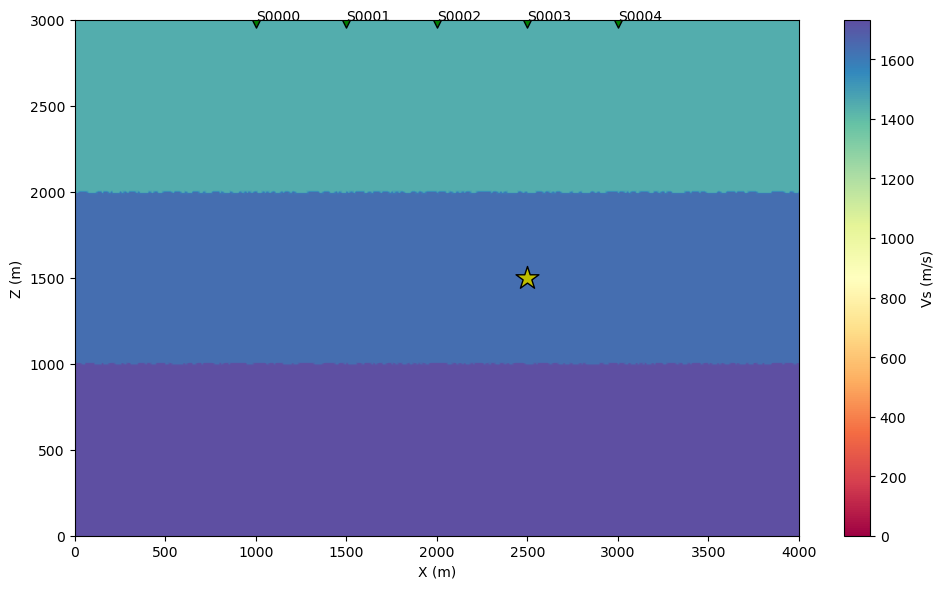

In [162]:
# This will help plot the models from the binary database files

def read_bin_file(filename):
    nbytes = os.path.getsize(filename)
    with open(filename, "rb") as file:
        n = np.fromfile(file, dtype="int32", count=1)[0]
        if n == nbytes - 8:
            file.seek(4)
            data = np.fromfile(file, dtype="float32")
            return data[:]
        else:
            file.seek(0)
            return np.fromfile(file, dtype="float32")


def read_all_partitions(bin_dir, nproc=4):
    data_x_all, data_z_all, data_vs_all, data_vp_all = [], [], [], []

    for i in range(nproc):
        suffix = f"{i:06d}"
        xfile  = os.path.join(bin_dir, f"proc{suffix}_x.bin")
        zfile  = os.path.join(bin_dir, f"proc{suffix}_z.bin")
        vsfile = os.path.join(bin_dir, f"proc{suffix}_vs.bin")
        vpfile = os.path.join(bin_dir, f"proc{suffix}_vp.bin")

        data_x_all.append(read_bin_file(xfile))
        data_z_all.append(read_bin_file(zfile))
        data_vs_all.append(read_bin_file(vsfile))
        data_vp_all.append(read_bin_file(vpfile))

    return (np.concatenate(data_x_all),
            np.concatenate(data_z_all),
            np.concatenate(data_vs_all),
            np.concatenate(data_vp_all))

def plot_model(bin_dir="DATA/", nproc=4, cmap="Spectral", param="vs",
               res_x=800, res_z=400):
    """
    Reads proc binary files, SOURCE, STATIONS,
    then plots Vs or Vp using grid interpolation (no tricontourf).
    """

    # --- Read model values ---
    data_x, data_z, data_vs, data_vp = read_all_partitions(bin_dir, nproc=nproc)

    # Select which parameter to plot
    if param.lower() == "vp":
        data = data_vp
        label = "Vp (m/s)"
    else:
        data = data_vs
        label = "Vs (m/s)"

    # --- Read STATIONS ---
    sta_x, sta_z = np.genfromtxt("DATA/STATIONS", dtype=float, usecols=[2, 3]).T
    sta_id       = np.genfromtxt("DATA/STATIONS", dtype=str,   usecols=[0]).T

    # --- Read source ---
    with open("DATA/SOURCE", "r") as f:
        lines = f.readlines()
    ev_x = float(lines[2].split("=")[1].split("#")[0].strip())
    ev_z = float(lines[3].split("=")[1].split("#")[0].strip())

    # --- Color limits ---
    vmin, vmax = np.min(data), np.max(data)

    xi = np.linspace(np.min(data_x), np.max(data_x), res_x)
    zi = np.linspace(np.min(data_z), np.max(data_z), res_z)
    X, Z = np.meshgrid(xi, zi)

    V = griddata((data_x, data_z), data, (X, Z), method="linear")

    # Plot image
    plt.figure(figsize=(10, 6))
    img = plt.imshow(V,
                     extent=[min(data_x), max(data_x),
                             min(data_z), max(data_z)],
                     origin="lower",
                     cmap=cmap,
                     vmin=vmin, vmax=vmax,
                     aspect="auto")

    cbar = plt.colorbar(img)
    cbar.set_label(label)

    # --- Overlay stations ---
    for x_, z_, id_ in zip(sta_x, sta_z, sta_id):
        plt.scatter(x_, z_, c="g", marker="v", edgecolor="k", s=120)
        plt.text(x_, z_, id_)

    # --- Plot source ---
    plt.scatter(ev_x, ev_z, c="y", marker="*", edgecolor="k", s=300)

    plt.xlabel("X (m)")
    plt.ylabel("Z (m)")
    plt.tight_layout()
    plt.show()

plot_model("DATA/", nproc=4, param="vs")


- The model above shows shear wave velocities (Vs in m/s) in a 2D domain
- Our model is defined by 3 distinct layers (compare to interfaces file previously). 
    - Top: Z=3500m to Z=2000m, features a moderate velocity with topography at the surface (Z>3000m). 
    - Middle: Z=2000m to Z=1000m shows a low velocity zone with a high-velocity column (turquoise square). 
    - Bottom: Z=1000m to Z=0m, features a realtively fast velocity. 
- 22 Station locations (green triangles), along the top boundary, and in a 'borehole' below the event
- 1 event (yellow star) colocated with station S0012

----------
We can check the material properties against those defined in the `Par_file`
```bash
N - RHO     VP[m/s] VS[m/s]    - - QKAP QMU  - - - - -
1 1 2700.d0 3000.d0 1732.d0 0 0 9999 9999 0 0 0 0 0 0
2 1 2500.d0 2700.d0 1632.d0 0 0 9999 9999 0 0 0 0 0 0
3 1 2200.d0 2500.d0 1443.d0 0 0 9999 9999 0 0 0 0 0 0
```

#### 4b) Synthetic waveforms

- During the simulation, `xspecfem2D` initiated the `SOURCE` file at time T=0  
- Over the course of the simulation, seismic waves propogated outward and were recorded at receiver locations defined by `STATIONS`   
- Each `STATION` has a corresponding synthetic seismogram located in the *OUTPUT_FILES/* directory.

#### Synthetic Filename Formats
- Synthetic seismograms have file extension `.semd` because they are output in displacement (set by parameter `seismotype`)  
- 'd' in .semd stands for **d**isplacement. Velocity seismograms would be extension'ed `.semv`, acceleration `.sema`. **This is the same in SPECFEM3D**
- For simplicity we have chosen to output our synthetics in ACSII format. These ASCII files are two columns, representing time and amplitude, respectively.

In [163]:
# We have generated synthetics for each station location shown above
! ls OUTPUT_FILES/*.semd
! echo

# The first 10 lines of a seismogram show the two-column (time, amplitude) format
! head -10 OUTPUT_FILES/AA.S0001.BXX.semd

OUTPUT_FILES/AA.S0000.BXX.semd	OUTPUT_FILES/AA.S0002.BXZ.semd
OUTPUT_FILES/AA.S0000.BXZ.semd	OUTPUT_FILES/AA.S0003.BXX.semd
OUTPUT_FILES/AA.S0001.BXX.semd	OUTPUT_FILES/AA.S0003.BXZ.semd
OUTPUT_FILES/AA.S0001.BXZ.semd	OUTPUT_FILES/AA.S0004.BXX.semd
OUTPUT_FILES/AA.S0002.BXX.semd	OUTPUT_FILES/AA.S0004.BXZ.semd

 -0.12000000000000000          0.0000000000000000     
 -0.11889999999999999          0.0000000000000000     
 -0.11780000000000000          0.0000000000000000     
 -0.11670000000000000          0.0000000000000000     
 -0.11559999999999999          0.0000000000000000     
 -0.11449999999999999          0.0000000000000000     
 -0.11340000000000000          0.0000000000000000     
 -0.11230000000000000          0.0000000000000000     
 -0.11119999999999999          0.0000000000000000     
 -0.11009999999999999          0.0000000000000000     


Text(0, 0.5, 'Displacement [m]')

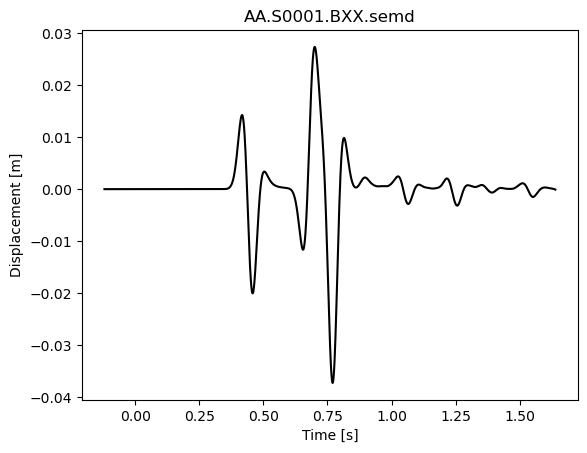

In [164]:
# Plot seismograms using NumPy and Matplotlib
data = np.loadtxt("OUTPUT_FILES/AA.S0001.BXX.semd", dtype=float)

plt.plot(data[:,0], data[:,1], c="k")
plt.title("AA.S0001.BXX.semd")
plt.xlabel("Time [s]")
plt.ylabel("Displacement [m]")

#### 4c) SPECFEM2D Wavefield Snapshots 

- `xspecfem2D` generates JPEG snapshots of the forward wavefield during a simulation  
- This is specific to SPECFEM2D, for **SPECFEM3D**, you will need to output data arrays of each snapshot, which are visualized separately  
- The `Par_file` parameter `NTSTEP_BETWEEN_OUTPUT_IMAGES` controls how often figures are generated during a simulation. 
- We can see below that `DT`=.0011, so we output images every 0.11s of simulation time. 

In [172]:
# Wavefield snapshots every 100 time steps
! ls OUTPUT_FILES/*.jpg

OUTPUT_FILES/forward_image000000005.jpg
OUTPUT_FILES/forward_image000000100.jpg
OUTPUT_FILES/forward_image000000200.jpg
OUTPUT_FILES/forward_image000000300.jpg
OUTPUT_FILES/forward_image000000400.jpg
OUTPUT_FILES/forward_image000000500.jpg
OUTPUT_FILES/forward_image000000600.jpg
OUTPUT_FILES/forward_image000000700.jpg
OUTPUT_FILES/forward_image000000800.jpg
OUTPUT_FILES/forward_image000000900.jpg
OUTPUT_FILES/forward_image000001000.jpg
OUTPUT_FILES/forward_image000001100.jpg
OUTPUT_FILES/forward_image000001200.jpg
OUTPUT_FILES/forward_image000001300.jpg
OUTPUT_FILES/forward_image000001400.jpg
OUTPUT_FILES/forward_image000001500.jpg
OUTPUT_FILES/forward_image000001600.jpg


At time step 300 (T=0.33s), we can see the P- and S-wave wavefronts (alternative red and blue) radiating from the source location  

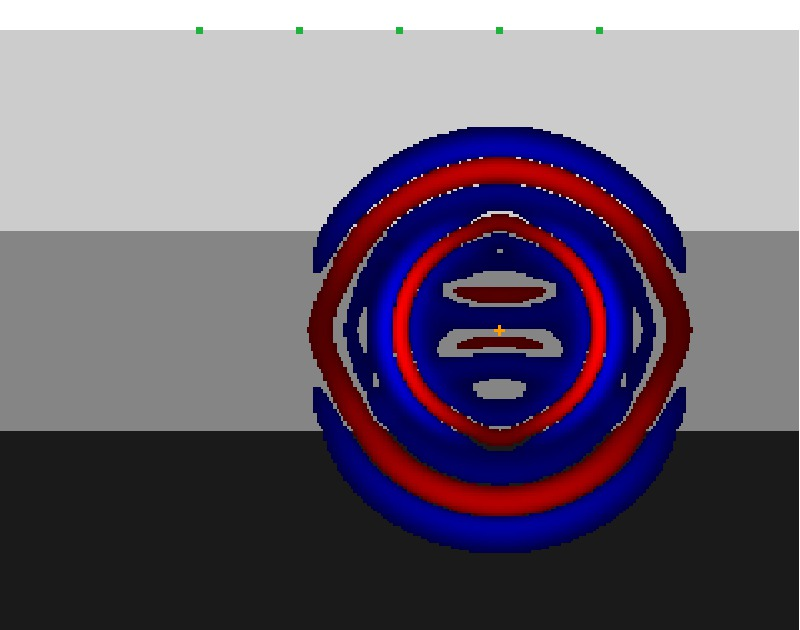

In [175]:
Image("OUTPUT_FILES/forward_image000000400.jpg")

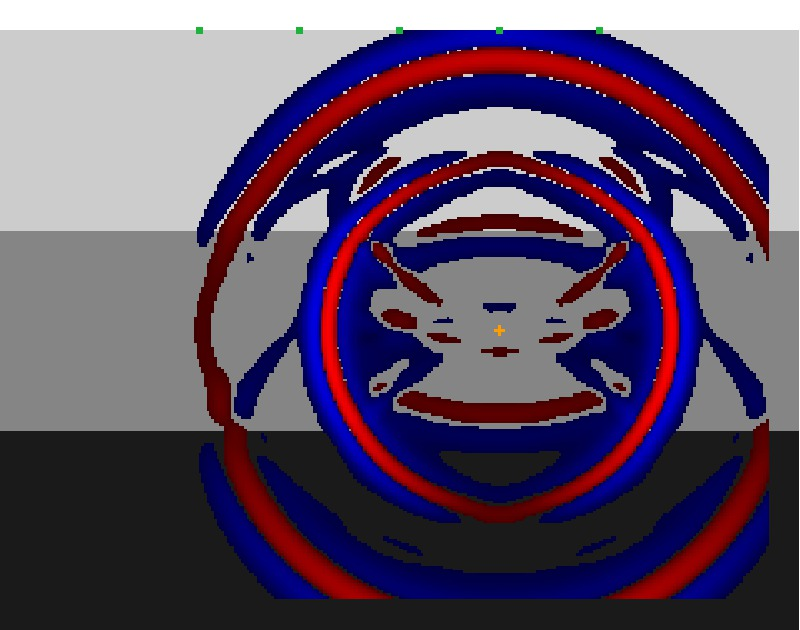

In [180]:
Image("OUTPUT_FILES/forward_image000000600.jpg")

### 5) Another Example

#### 5a) Set Up a SPECFEM Working Directory


In [208]:
# Create the correct dir. and move there
! mkdir -p /home/visrutha/work/specfem2d_workdir_curved
%cd /home/visrutha/work/specfem2d_workdir_curved

# Symlink the executables, copy example DATA/, create empty OUTPUT_FILES
! ln -s /home/visrutha/specfem2d/bin .
! cp -r /home/visrutha/specfem2d/EXAMPLES/simple_topography_and_also_a_simple_fluid_layer/DATA .
! mkdir OUTPUT_FILES

! ls

/home/visrutha/work/specfem2d_workdir_curved
ln: failed to create symbolic link './bin': File exists
mkdir: cannot create directory ‘OUTPUT_FILES’: File exists
bin  DATA  OUTPUT_FILES


In [213]:
# modify parameters

! grep "^NPROC" DATA/Par_file
! sed -i 's/^NPROC.*/NPROC = 8/' DATA/Par_file
! grep "^NPROC" DATA/Par_file


! grep "^setup_with_binary_database" DATA/Par_file
! sed -i 's/^setup_with_binary_database.*/setup_with_binary_database = 1/' DATA/Par_file
! grep "^setup_with_binary_database" DATA/Par_file

! grep "^SAVE_MODEL" DATA/Par_file
! sed -i 's/^SAVE_MODEL.*/SAVE_MODEL = binary/' DATA/Par_file
! grep "^SAVE_MODEL" DATA/Par_file

NPROC = 8
NPROC = 8
setup_with_binary_database = 1
setup_with_binary_database = 1
SAVE_MODEL = binary
SAVE_MODEL = binary


#### 5b) Run SPECFEM executables

In [211]:
! mpirun -n 8 bin/xmeshfem2D > OUTPUT_FILES/output_meshfem2d.txt
! /usr/bin/mpirun -n 8 bin/xspecfem2D > OUTPUT_FILES/output_specfem2d.txt

#### 5c) Plot output files

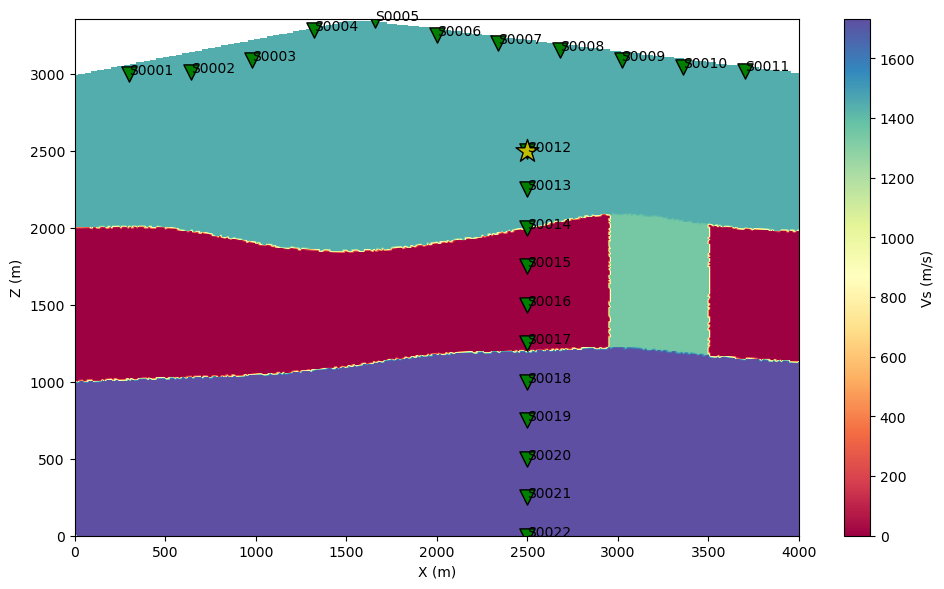

In [214]:
plot_model("DATA/", nproc=8, param="vs")


Text(0, 0.5, 'Displacement [m]')

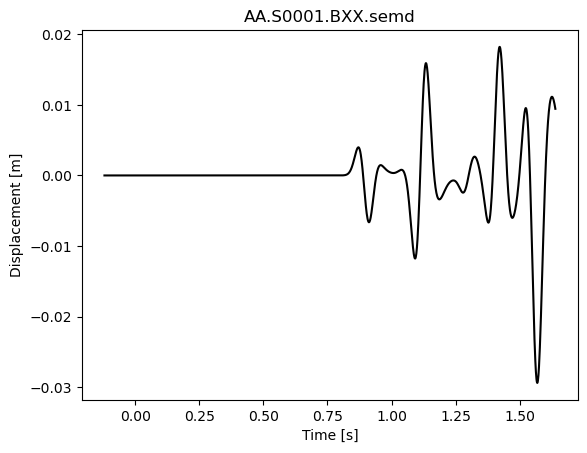

In [217]:
# Plot seismograms using NumPy and Matplotlib
data = np.loadtxt("OUTPUT_FILES/AA.S0001.BXX.semd", dtype=float)

plt.plot(data[:,0], data[:,1], c="k")
plt.title("AA.S0001.BXX.semd")
plt.xlabel("Time [s]")
plt.ylabel("Displacement [m]")

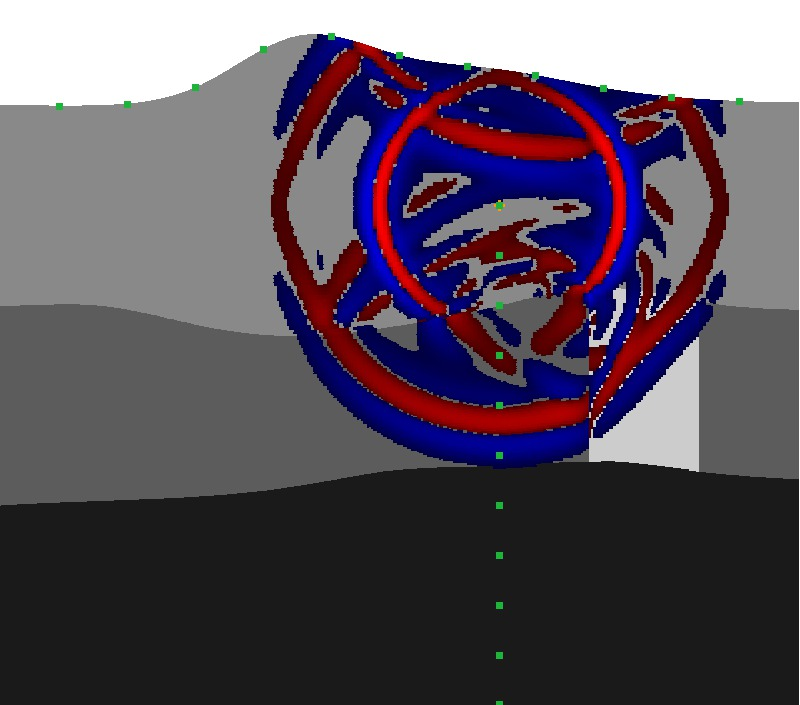

In [218]:
Image("OUTPUT_FILES/forward_image000000500.jpg")

### 6) Conclusions

- In this notebook we explored SPECFEM2D, and learned to run the default example mesh generation and forward simulation.  
- We took a look at the most important files required for a simulation, and how User's can manipulate various parameters and files to run their own simulations. 
- We had a look at the results of a SPECFEM2D simulation, including waveforms, models, and wavefield snapshots.